('outdir ', '/tmp/user/1000/tmprTN17O')


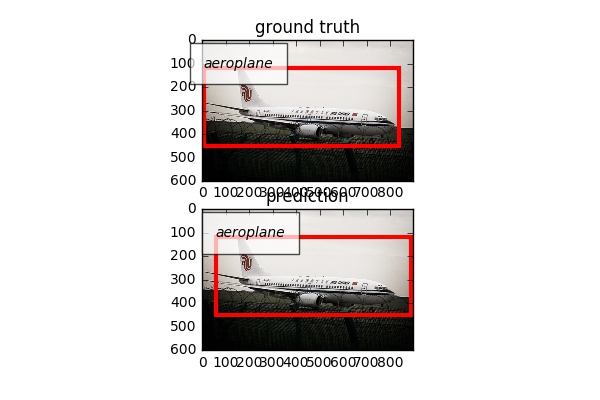

In [8]:
from chainercv.datasets import VOCDetectionDataset
from chainercv.testing import ConstantReturnModel
from chainercv.extensions import DetectionVisReport
import mock
import tempfile
from chainercv import transforms
from IPython.display import Image 



def _shape_soft_min_hard_max(img_shape, soft_min, hard_max):
    lengths = np.array(img_shape).astype(np.float)
    min_length = np.min(lengths)
    scale = float(soft_min) / min_length
    lengths *= scale

    max_length = np.max(lengths)
    if max_length > hard_max:
        lengths *= float(hard_max) / max_length
    out_shape = (int(np.asscalar(lengths[0])),
                 int(np.asscalar(lengths[1])))
    return out_shape



def transform(in_data):
    img, bbox = in_data
    # img -= np.array([103.939, 116.779, 123.68])[:, None, None]

    # Resize bounding box to a shape
    # with the smaller edge at least at length 600
    input_shape = img.shape[1:]
    output_shape = _shape_soft_min_hard_max(input_shape, 600, 1200)
    img = transforms.resize(img, output_shape)
    bbox = transforms.resize_bbox(bbox, input_shape, output_shape)

    # horizontally flip
    img, flips = transforms.random_flip(
        img, horizontal_flip=True, return_flip=True)
    h_flip = flips['h']
    bbox = transforms.flip_bbox(bbox, output_shape, h_flip)
    return img, bbox


train_data = VOCDetectionDataset(mode='train', use_cache=True, year='2007')
transforms.extend(train_data, transform)
_, bbox = train_data.get_example(3)

model = ConstantReturnModel(bbox[None])

trainer = mock.MagicMock()
out_dir = tempfile.mkdtemp()
print('outdir ', out_dir)
trainer.out = out_dir
trainer.updater.iteration = 0
extension = DetectionVisReport([3], train_data, model)
extension(trainer)


Image(filename=os.path.join(trainer.out, 'detection_idx=3_iter=0.jpg'))
